## Immersive plotting and analyzing results

In [1]:
import xarray as xr
import pyorc

You have a result stored in a NetCDF file after running notebook 02. Now you want to see if the results seem to make sense, and further analyze these. Especially post-processing of your results with filter is an essential step in most velocimetry analyses, given that sometimes hardly any tracers are visible, and only spuriously correlated results were found. With some intelligence these suspicious velocities can be removed, and `pyorc` has many methods available to do that. Most of these can be applied without any parameter changes for a good results. 

Let's first have a look at the file structure. We can simply use the `xarray` API to open the result file.

In [2]:
ds = xr.open_dataset("ngwerere/ngwerere_piv.nc")
ds


<xarray.Dataset>
Dimensions:  (time: 124, x: 83, y: 63)
Coordinates:
  * time     (time) float64 0.01667 0.05 0.08333 0.1167 ... 4.05 4.083 4.117
  * y        (y) float64 8.125 7.995 7.865 7.735 ... 0.455 0.325 0.195 0.065
  * x        (x) float64 0.065 0.195 0.325 0.455 ... 10.34 10.47 10.6 10.73
    xp       (y, x) float32 ...
    yp       (y, x) float32 ...
    xs       (y, x) float64 ...
    ys       (y, x) float64 ...
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
Data variables:
    v_x      (time, y, x) float32 ...
    v_y      (time, y, x) float32 ...
    s2n      (time, y, x) float32 ...
    corr     (time, y, x) float32 ...
Attributes:
    camera_shape:   [1080, 1920]
    camera_config:  {\n    "crs": "PROJCRS[\"WGS 84 / UTM zone 35S\",BASEGEOG...
    h_a:            null

As you can see, we have lots of coordinate variables at our disposal, these can be used in turn to plot our data in a local projection, with our bounding box top-left corner at the top-left. The `x` and `y` axes hold the local coordinates. We can also use the UTM35S coordinates, stored in `xs` and `ys`, the longitude and latitude coordinates stored in `lon` and `lat`, or....(very cool) the original row and column coordinate of the camera's objective. This allows us to plot the results as an augmented reality view.

In the data variables, we see `v_x` and `v_y` for the x-directional and y-directional velocity, measured long the `x` and `y` axis of the local coordinate system. Furthermore we see the `s2n` variable containing the signal to noise ratio computed by the underlying used library OpenPIV. This ratio is computed as the ratio between the highest correlation and the second highest correlation found in the surroundings of each window. We also store the highest correlation found in the variable `corr`. As this is done for each frame to frame pair, the dataset contain 124 time steps, since we extract 125 frames.

Because we used a 0.01 resolution and a 25 pixel interrogation window, and `pyorc` typically uses an overlap between windows of 50%, the `y` and `x` coordinates have a spacing of `25 * 0.01 * 0.5 = 0.125 cm` (rounded to 0.13).

Finally, a lot of attributes are stored in a serializable form, so that the dataset can be stored in NetCDF, and the camera configuration and other information needed can be used after loading.


### Plotting in local projection
Both a frames `DataArray` and a velocimetry `Dataset` have plotting functionalities that can be used to combine information into a plot. The default is to plot data in the local projection that follows the area of interest bounding box, but geographical plots or camera perspectives can also be plotted. Let's start with an rgb frame with the PIV results on top. We cannot plot the time dimension, so we apply a `mean` reducer first.

Note that whilst plotting velocimetry results, we can supply `kwargs_scalar` and `kwargs_quiver`. These are meant to pass arguments to plotting of the scalar velocity values (plotted as a mesh) and the vectors (plotted as arrows).

/home/hcwinsemius/miniconda3/envs/pyorc/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


<AxesSubplot:>

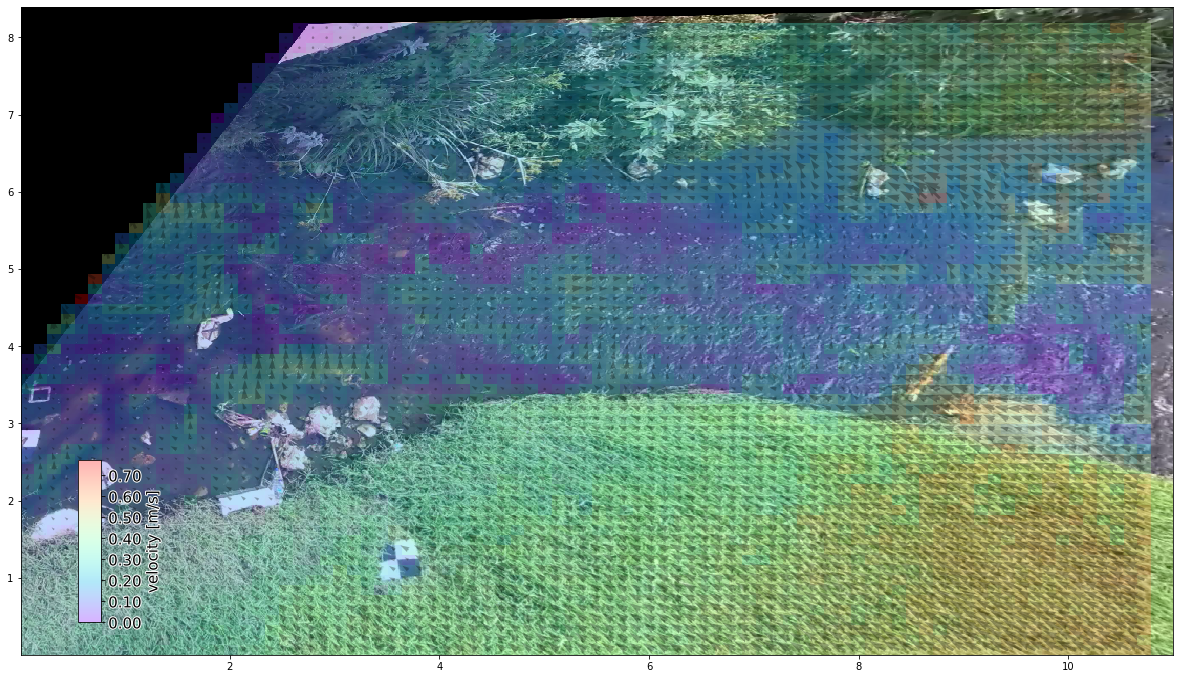

In [26]:
# first re-open the original video, extract one RGB frame and plot that
video_file = "ngwerere/ngwerere_20191103.mp4"

video = pyorc.Video(video_file, start_frame=0, end_frame=125)
# borrow the camera config from the velocimetry results
video.camera_config = ds.velocimetry.camera_config

da_rgb = video.get_frames(grayscale=False)
# project the rgb frame
da_rgb_proj = da_rgb.frames.project()
# plot the first frame (we only have one) without any arguments, default is to use "local" mode
ax = da_rgb_proj[0].frames.plot()

# now plot the results on top, we use the mean, because we cannot plot more than 2 dimensions. 
# We give the existing axis handle to plot on, and some transparency
ds_q = ds.quantile([0.1], dim="time", keep_attrs=True)
ds_q.isel(quantile=0)

ds_q.isel(quantile=0).velocimetry.plot(
    ax=ax,
    scalar_kwargs=dict(alpha=0.3, cmap="rainbow"),
    quiver_kwargs=dict(alpha=0.3)
)


### Filtering of results
Already this looks very promising. But we haven't yet analyzed any of the velocities for spurious values. Even over land we have estimates of velocities, while we would not expect that. We have a set of temporal filters which analyze for spurious values by comparing over time steps, and spatial filters, which compare neighbouring grid cell values to flag spurious values. Let's apply all temporal filters top see what we have. 

/home/hcwinsemius/miniconda3/envs/pyorc/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


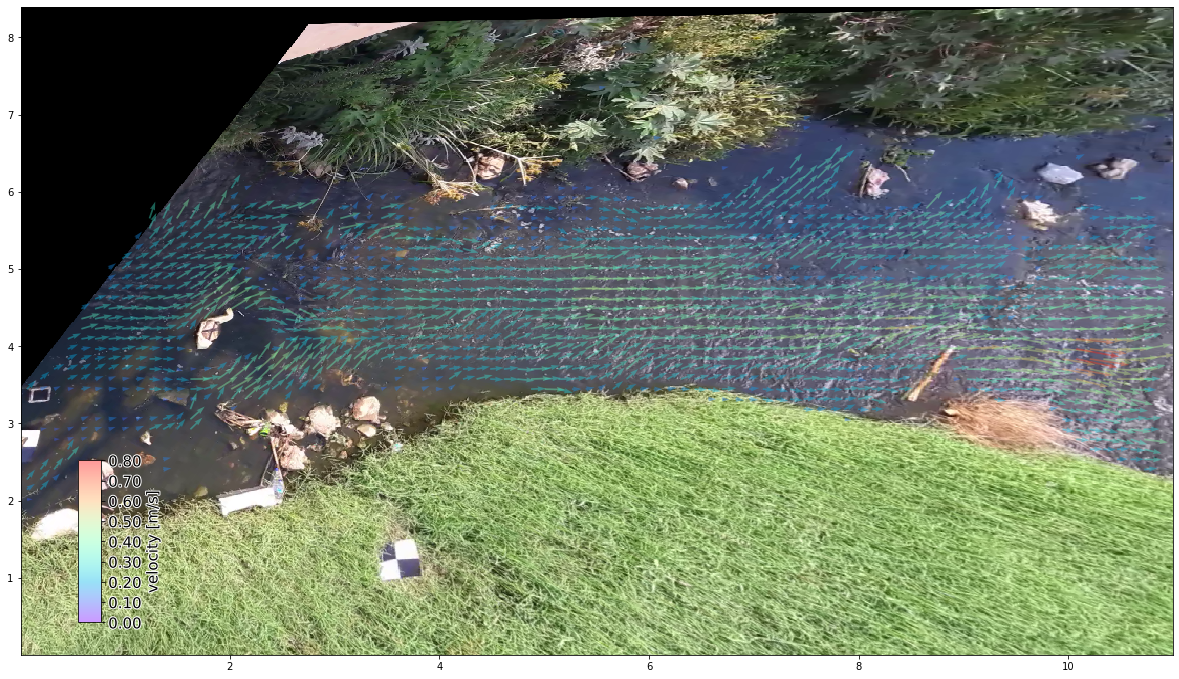

In [12]:
# simply apply all filters in time domain, this is done by calling .filter_temporal without arguments.
ds_filt = ds.velocimetry.filter_temporal()

# apply the plot again, let's leave out the scalr values, and make the quivers a bit nicer than before.

ds_mean_filt = ds_filt.mean(dim="time")

ds_q = ds_filt.quantile(0.1, dim="time", keep_attrs=True)
# ds_q = ds_q.isel(quantile=0)


# again the rgb frame first
ax = da_rgb_proj[0].frames.plot()

#...and then filtered velocimetry
ax = ds_q.velocimetry.plot(
    ax=ax,
    scalar=False,
    quiver_kwargs={"alpha": 0.4, "cmap": "rainbow", "scale": 20, "width": 0.0015, "vmin": 0., "vmax": 0.8},  # "scale": 1000,
)


Interesting! We see that the velocities become a lot higher on average. Most likely because many spurious velocities are removed. We also see that the velocities seem to be more left-to-right oriented. In part this may be because we applied the `.filter_temporal_angle` method under the hood. This filter removes velocities that are in a direction, far off from the expected direction. The default direction of this filter is always left to right. Therefore take good care of this filter, if you decide to apply `pyorc` in a bottom to top direction.

As this stream is very shallow and has lots of obstructions like rocks that the water goes around, the application of this filter may have removed many velocities that were actually correct. Let's do the filtering again, but whilst leaving out the angular filter.


/home/hcwinsemius/miniconda3/envs/pyorc/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


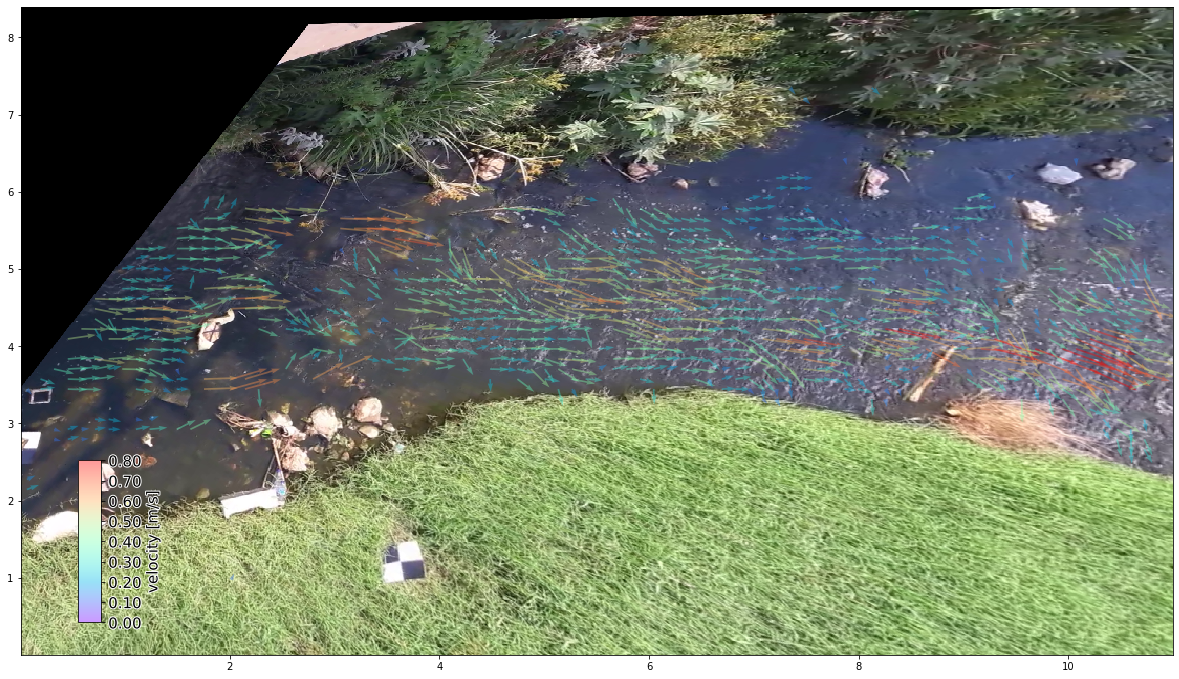

In [45]:
# apply all filters in time domain except for the angle filter, this is done by calling .filter_temporal without arguments.
import numpy as np
ds_filt2 = ds.velocimetry.filter_temporal(kwargs_angle=dict(angle_tolerance=0.5*np.pi))
ds_filt2.velocimetry.filter_spatial(filter_nan=False, inplace=True, kwargs_median=dict(stride=2))
# apply the plot again, let's leave out the scalr values, and make the quivers a bit nicer than before.

ds_mean_filt2 = ds_filt2.mean(dim="time", keep_attrs=True)

ds_q = ds_filt2.quantile(0.1, dim="time", keep_attrs=True)

frame = 15
# again the rgb frame first
ax = da_rgb_proj[frame].frames.plot()

#...and then filtered velocimetry
ax = ds_filt2.isel(time=frame).velocimetry.plot(
    ax=ax,
    scalar=False,
    quiver_kwargs={"alpha": 0.4, "cmap": "rainbow", "scale": 20, "width": 0.0015, "vmin": 0., "vmax": 0.8},  # "scale": 1000,
)


It looks more natural. Check for instance the pattern around the rock on the left side. Now we can also plot in a geographical view.

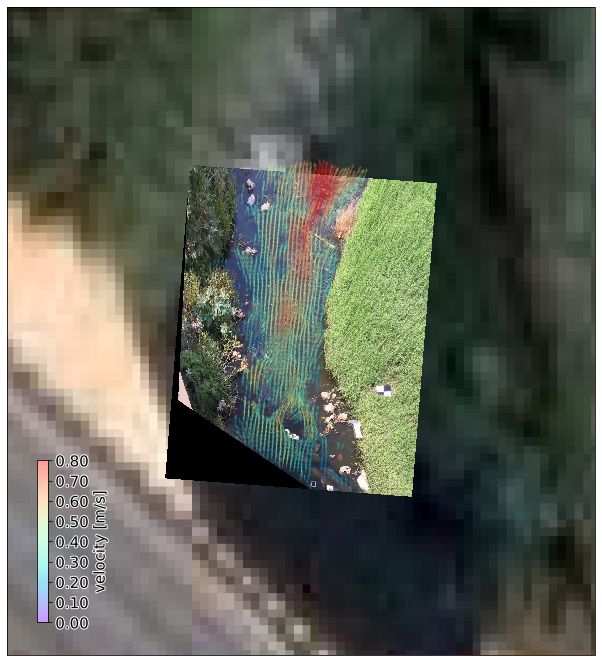

In [46]:
# again the rgb frame first. But now we use the "geographical" mode to plot on a map
ax = da_rgb_proj[0].frames.plot(mode="geographical")

#...and then filtered velocimetry again, but also geographical
ax = ds_mean_filt2.velocimetry.plot(
    ax=ax,
    scalar=False,
    mode="geographical",
    quiver_kwargs={"alpha": 0.4, "cmap": "rainbow", "scale": 20, "width": 0.0015, "vmin": 0., "vmax": 0.8},  # "scale": 1000,
)
# for fun, let's also add a satellite background from cartopy
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
tiles = cimgt.GoogleTiles(style="satellite")
ax.add_image(tiles, 19)
# zoom out a little bit so that we can actually see a bit
ax.set_extent([
    da_rgb_proj.lon.min() - 0.00005,
    da_rgb_proj.lon.max() + 0.00005,
    da_rgb_proj.lat.min() - 0.00005,
    da_rgb_proj.lat.max() + 0.00005],
    crs=ccrs.PlateCarree()
)


### Immersive and intuitive augmented reality
And now the most beautiful plot you can make with pyorc: an augmented reality view. For this, we need an unprojected rgb frame and supply the `mode="camera"` keyword argument.

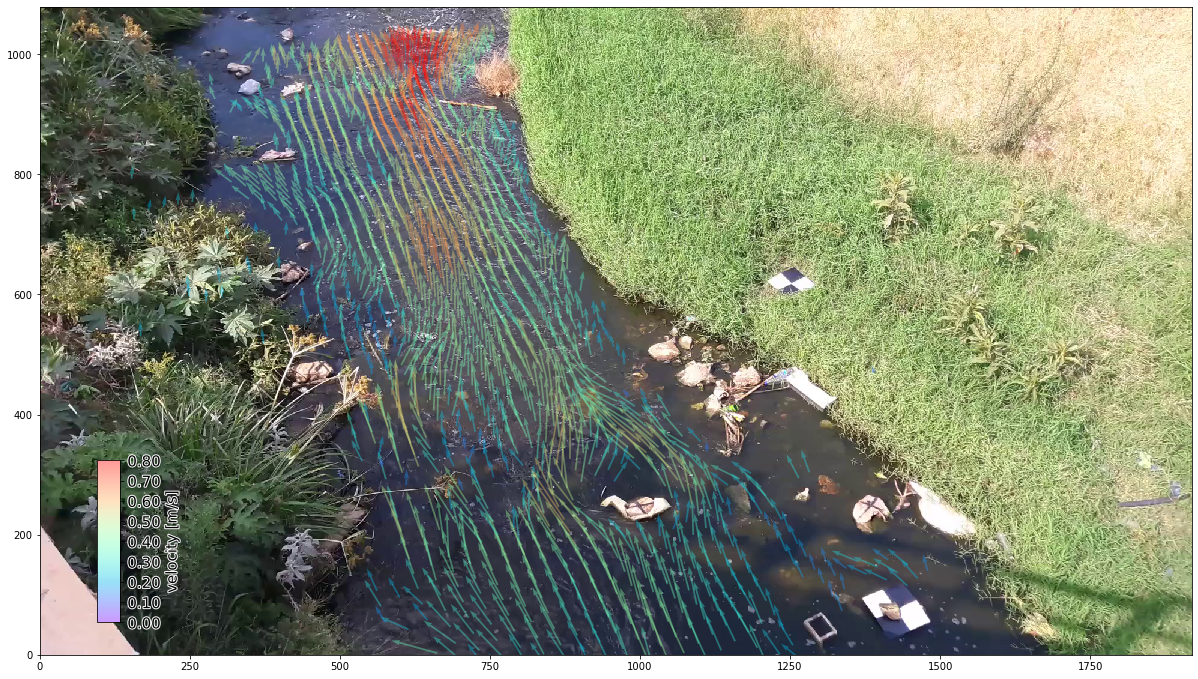

In [47]:
# again the rgb frame first, but now the unprojected one. Now we use the "camera" mode to plot the camera perspective
ax = da_rgb[0].frames.plot(mode="camera")

#...and then filtered velocimetry again, but also camera. This gives us an augmented reality view. The quiver scale 
# needs to be adapted to fit in the screen properly
ax = ds_mean_filt2.velocimetry.plot(
    ax=ax,
    scalar=False,
    mode="camera",
    quiver_kwargs={"alpha": 0.4, "cmap": "rainbow", "scale": 200, "width": 0.0015, "vmin": 0., "vmax": 0.8},  # "scale": 1000,
)


### Store the final filtered results
Let's also store the filtered velocities in a separate file. To ensure it remains really small, we can use the `.set_encoding` method first, to ensure the variables are encoded to integer values before storing. This makes the file nice and small.

In [49]:
ds_filt2.velocimetry.set_encoding()
ds_filt2.to_netcdf("ngwerere_filtered.nc")